# MHC1 Presentation

The goal of this notebook is to develop a classifier capable of predicting whether a given peptide will be presented by a specific MHC class I (MHC-I) protein, identified by its allele name. To achieve this, we will follow these steps:

1. **Data Analysis and Processing**:
    - Explore and preprocess the data to ensure it's in a suitable format for modeling.

2. **Data Encoding**:
    - Convert the peptide sequences and MHC-I allele information into numerical representations that can be used by machine learning models.

3. **Machine Learning**:
    - Implement and evaluate traditional machine learning models to establish baseline performance.

4. **Deep Learning**:
    - Use pre-tained protein language model to extract meainingfull embeddings from the dataset. Then, train a linear neural network and compare resutls to baseline.


In [ ]:
!pip install -r requirments.txt

In [2]:
import gc 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import xgboost as xgb
import torch
from torch.utils.data import DataLoader
import mhcflurry

from encoders import ProteinEncoder, ProttransEncoder
from datasets import ProteinSequenceDataset, EmbeddingDataset
from models import ClassificationHead
from train import train_model
from eval import eval_model, compute_metrics
from losses import FocalLoss, GCE
import plotting


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

 A C D E F G H I K L M N P Q R S T V W Y
['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


f:\IA\test_instadeep_nlp\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


# 1. Data Analysis and Processing

In this section, we will analyze our training and testing datasets, then clean and preprocess them to ensure they are ready for the next steps.

In [2]:
df_train_1 = pd.read_csv("netmhcpan41_data/fold_0.csv")
df_train_2 = pd.read_csv("netmhcpan41_data/fold_1.csv")
df_train_3 = pd.read_csv("netmhcpan41_data/fold_2.csv")
df_train_4 = pd.read_csv("netmhcpan41_data/fold_3.csv")
df_train_5 = pd.read_csv("netmhcpan41_data/fold_4.csv")

In [3]:
df_train = pd.concat([df_train_1, df_train_2,df_train_3,df_train_4,df_train_5]).reset_index(drop=True)

del df_train_1
del df_train_2
del df_train_3
del df_train_4
del df_train_5

df_test = pd.read_csv("netmhcpan41_data/test.csv")

In [4]:
df_train

,peptide,allele,hit
0,YFPLAPFNQL,HLA-C*14:02,1
1,KESKINQVF,HLA-B*44:02,1
2,QPHDPLVPLSA,HLA-B*54:01,1
3,RTIADSLINSF,HLA-B*57:03,1
4,EEKTIIKKL,HLA-B*44:03,1
...,...,...,...
3679400,YTLSSDQA,HLA-C*17:01,0
3679401,YVKNPEIFT,HLA-C*17:01,0
3679402,YVTEEDGT,HLA-C*17:01,0
3679403,YWSLHQTTPSS,HLA-C*17:01,0


In [5]:
df_test

,peptide,hit,allele
0,AAPATRAAL,1,HLA-B35:03
1,AAPSAAREL,1,HLA-B35:03
2,AEISQIHQSVTD,1,HLA-B35:03
3,ALEEQLQQIRAE,1,HLA-B35:03
4,AQDPLLLQM,1,HLA-B35:03
...,...,...,...
946136,YDPEAVLPEHLRQH,0,HLA-A02:11
946137,TGAVGVVGRSASFA,0,HLA-A02:11
946138,KITLRRFSVVEKSD,0,HLA-A02:11
946139,RVLELLQKNRDMTF,0,HLA-A02:11


In the test CSV file, we notice that the alleles do not follow the HLA nomenclature, as the separator (*) between the gene and allele group is missing. Let's correct this using a regex.

In [6]:
df_test['allele'] = df_test['allele'].str.replace(r'^(HLA-[A-Z])(\d+:\d+)$', r'\1*\2', regex=True)
df_test

,peptide,hit,allele
0,AAPATRAAL,1,HLA-B*35:03
1,AAPSAAREL,1,HLA-B*35:03
2,AEISQIHQSVTD,1,HLA-B*35:03
3,ALEEQLQQIRAE,1,HLA-B*35:03
4,AQDPLLLQM,1,HLA-B*35:03
...,...,...,...
946136,YDPEAVLPEHLRQH,0,HLA-A*02:11
946137,TGAVGVVGRSASFA,0,HLA-A*02:11
946138,KITLRRFSVVEKSD,0,HLA-A*02:11
946139,RVLELLQKNRDMTF,0,HLA-A*02:11


Some peptides in the dataset contain an 'X' amino acid, which is not part of the valid amino acid list (ACDEFGHIKLMNPQRSTVWY). Let's remove these rows.

In [7]:
valid_amino_acids = set('ACDEFGHIKLMNPQRSTVWY')

def has_only_valid_amino_acids(peptide):
    return all(aa in valid_amino_acids for aa in peptide)

before = len(df_train)
df_train = df_train[df_train['peptide'].apply(has_only_valid_amino_acids)]
after = len(df_train)

print("Removed", before-after,"unvalid peptides in train")

before = len(df_test)
df_test = df_test[df_test['peptide'].apply(has_only_valid_amino_acids)]
after = len(df_test)

print("Removed", before-after,"unvalid peptides in test")

Removed 4 unvalid peptides in train
Removed 0 unvalid peptides in test


In [8]:
df_test.to_csv("netmhcpan41_data/df_test_cleaned_HLA.csv")

Let's now examine the unique values of peptides and alleles in the training and testing sets.

In [8]:
unique_peptide_train_set = set(df_train["peptide"])
unique_peptide_test_set = set(df_test["peptide"])

print("Unique peptides in train dataset :",len(unique_peptide_train_set))
print("Unique peptides in test dataset :",len(unique_peptide_test_set))

missing_peptides = unique_peptide_test_set - unique_peptide_train_set

print("Missing peptides from test in train:", len(missing_peptides))


unique_allele_train_set = set(df_train["allele"])
unique_allele_test_set = set(df_test["allele"])

print("Unique alleles in train dataset :", len(unique_allele_train_set))
print("Unique alleles in test dataset :", len(unique_allele_test_set))

missing_allele = unique_allele_test_set - unique_allele_train_set

print("Missing alleles from test in train:",len(missing_allele))
print(missing_allele)

Unique peptides in train dataset : 3584325
Unique peptides in test dataset : 935503
Missing peptides from test in train: 900434
Unique alleles in train dataset : 130
Unique alleles in test dataset : 36
Missing alleles from test in train: 4
{'HLA-A*02:11', 'HLA-A*02:02', 'HLA-A*33:01', 'HLA-B*53:01'}


We can see that the training set does not cover all the values present in the test set. This limitation will prevent us from using simple embedding methods, such as one-hot encoding, in the next steps.

Let's see if our datasets are balanced.

In [12]:
print("---------train-----------")
print(df_train["peptide"].value_counts())
print(df_train["allele"].value_counts())
print(df_train["hit"].value_counts())

---------train-----------
peptide
NNNNNNNNN        34
NNNNNNNNNN       31
NNNNNNNN         29
NNNNNNNNNNN      27
NNNNNNNNNNNNN    26
                 ..
YFAKPLLVWSRPS     1
YFDIEIDKV         1
YFEATEVNIMM       1
YFEKSKEQLT        1
YYRGAHGFL         1
Name: count, Length: 3584325, dtype: int64
allele
HLA-A*02:01    265252
HLA-B*07:02    201038
HLA-B*57:01    184773
HLA-A*29:02    181136
HLA-B*40:02    145817
                ...  
HLA-C*07:04        12
HLA-A*25:01         6
HLA-A*26:03         6
HLA-A*02:06         6
HLA-A*26:02         6
Name: count, Length: 130, dtype: int64
hit
0    3481858
1     197543
Name: count, dtype: int64


In [13]:
print("---------test-----------")
print(df_test["peptide"].value_counts())
print(df_test["allele"].value_counts())

---------test-----------
peptide
TFTVTEKPEVID      36
IAPTGHSL          35
HLPETKFSEL        35
TLKGETTTEAVD      34
TKTFTVTEKPEVID    34
                  ..
LDASDAETK          1
RAIAAEADG          1
QASSASTKG          1
DACGKKAIA          1
LFIWSFRRVAVKAT     1
Name: count, Length: 935503, dtype: int64
allele
HLA-A*02:02    77053
HLA-A*02:06    54510
HLA-A*02:11    48445
HLA-B*53:01    46991
HLA-B*15:17    45917
HLA-A*02:05    45136
HLA-B*15:03    44968
HLA-A*33:01    43333
HLA-A*66:01    41538
HLA-C*12:03    36448
HLA-C*03:03    35568
HLA-A*11:01    33424
HLA-A*30:02    33180
HLA-C*08:02    32416
HLA-A*23:01    30467
HLA-A*32:01    28036
HLA-B*40:02    23768
HLA-B*14:02    21601
HLA-B*37:01    20048
HLA-B*40:01    18908
HLA-B*45:01    18750
HLA-B*18:01    18284
HLA-B*58:01    17946
HLA-B*15:02    16702
HLA-B*15:01    16624
HLA-A*30:01    15837
HLA-C*07:02    15293
HLA-B*46:01    14015
HLA-B*38:01     9509
HLA-B*35:03     8275
HLA-A*26:01     7730
HLA-C*05:01     7033
HLA-A*25:01    

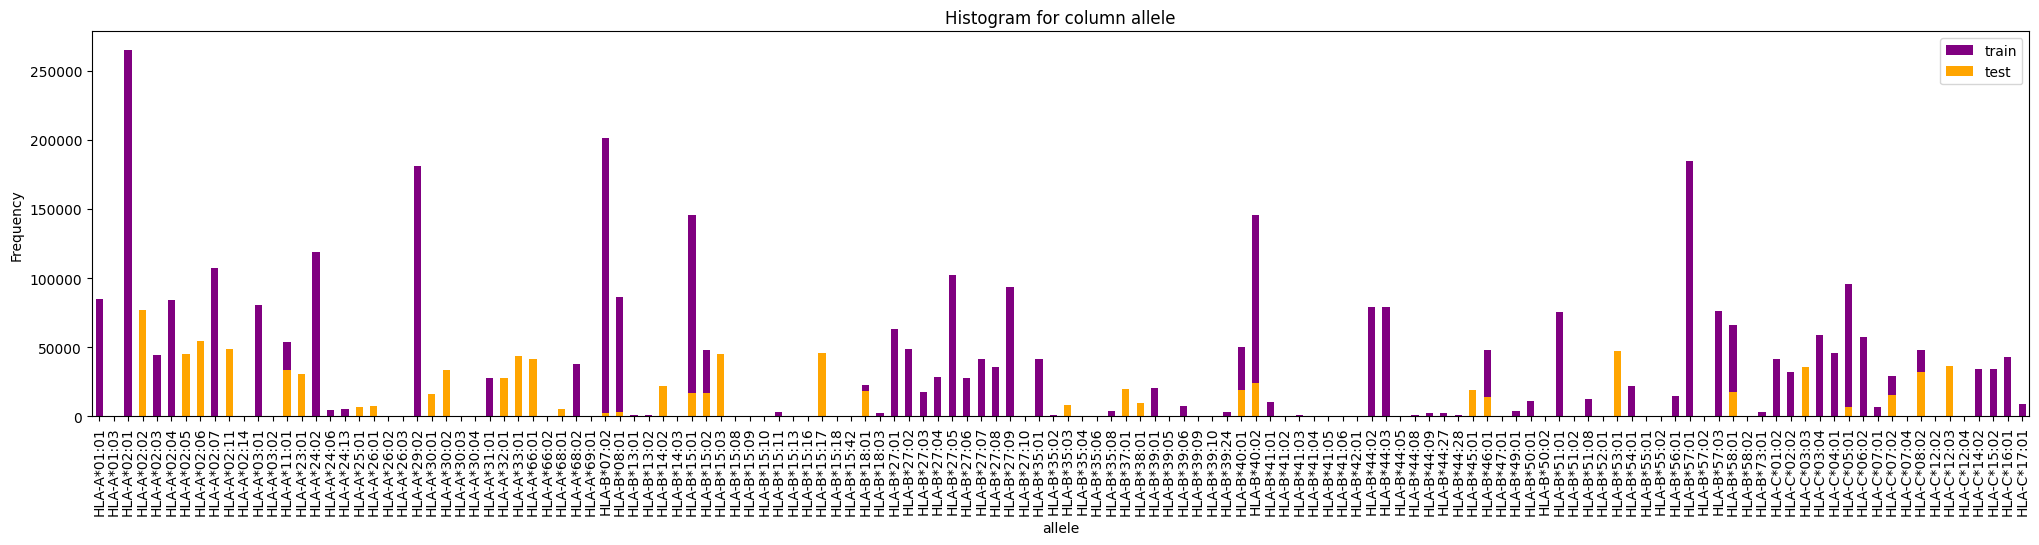

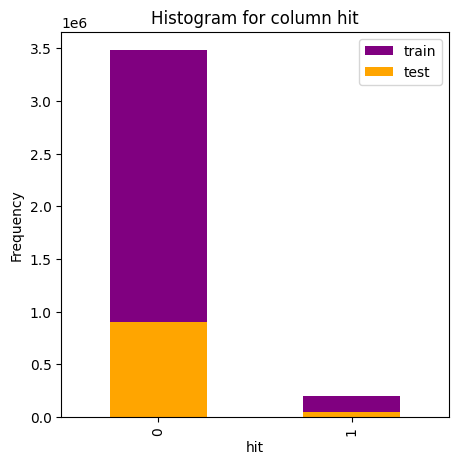

In [14]:
plotting.train_test_histogram(df_train, df_test, "allele", figsize=(25,5))
plotting.train_test_histogram(df_train, df_test, "hit",figsize=(5,5))

We can see that both the training and test sets are heavily imbalanced. We will need to account for this during training and use appropriate metrics for evaluation.

Let's convert the HLA IDs in the 'allele' column to their corresponding pseudo-sequences. This transformation will allow us to use a protein sequence encoder to embed this column. To map alleles to their pseudo-sequences, we will use the MHC_pseudo.dat file provided by [DTU Health Tech](https://services.healthtech.dtu.dk/suppl/immunology/NAR_NetMHCpan_NetMHCIIpan/).

In [15]:
file_name = 'netmhcpan41_data/MHC_pseudo.dat'

with open(file_name, 'r') as file:
    lines = file.readlines()

parsed_data = [line.strip().split() for line in lines]
df_mapping = pd.DataFrame(parsed_data, columns=['BoLA_ID', 'Sequence'])
df_mapping['BoLA_ID'] = df_mapping['BoLA_ID'].str.replace(r'^(HLA-[A-Z])(\d+:\d+)$', r'\1*\2', regex=True)
df_mapping = df_mapping.rename(columns={'BoLA_ID': 'allele'})

print(df_mapping)

             allele                            Sequence
0       BoLA-100901  YYSMYREISENVYGSNLYLLYRDYTWEYLNYRWY
1       BoLA-100902  YYSEYREISENVYESNLYLLYRDYTWEYLNYRWY
2       BoLA-101901  YHTKYREISENVYGSNLYYDYDYYTWAVFNYRGY
3       BoLA-102001  YHTKYREISENVYGSNLYFLYMDYTWAVFNYRGY
4       BoLA-102101  YYTKYREISENVYGSNLYFQFRYYTWADFNYEGY
...             ...                                 ...
11368  Mamu-B*03901  YTELYEERAETTFVSTAYIWYDYYTWAEMAYRWY
11369  Mamu-B*05201  YSEMYEERAGNTFVNTAYIGYHHYTWAVLAYRWY
11370  Mamu-B*06601  YSYMYEEKAARTDVDTLYIIYRDYTWAVWAYTWY
11371  Mamu-B*08301  YSEMYEQNSARTDVDTLYITYRDYTWAAQAYRSY
11372  Mamu-B*08701  YSAMYEEKAGHTDENTLYLRSYRYTWAARAYRWY

[11373 rows x 2 columns]


Let's verify that all our HLA alleles are present in the file before proceeding with the mapping.

In [16]:
unique_bola_set = set(df_mapping["allele"])
print(len(unique_bola_set))
print(len(unique_allele_train_set))
print(unique_allele_train_set - unique_bola_set)

11360
130
set()


All of our alleles have corresponding sequences in the MHC_pseudo.dat file, so let's replace the values in the 'allele' column with their respective pseudo-sequences.

In [17]:
temp = pd.merge(df_train, df_mapping, on='allele')
temp['allele'] = temp['Sequence']
df_train = temp.drop(columns=['Sequence'])
df_train

,peptide,allele,hit
0,YFPLAPFNQL,YSAGYREKYRQTDVSNLYLWFDSYTWAERAYTWY,1
1,SFIPAVNDL,YSAGYREKYRQTDVSNLYLWFDSYTWAERAYTWY,1
2,NYMMRNAVL,YSAGYREKYRQTDVSNLYLWFDSYTWAERAYTWY,1
3,TYTTRIHL,YSAGYREKYRQTDVSNLYLWFDSYTWAERAYTWY,1
4,LYGPSSVSF,YSAGYREKYRQTDVSNLYLWFDSYTWAERAYTWY,1
...,...,...,...
3679396,LTLDPADTNNV,YYAMYRNNVAHTDANTLYIRYQNYTWAEWAYRWY,0
3679397,EVFEAVGQRAA,YYAMYRNNVAHTDANTLYIRYQNYTWAEWAYRWY,0
3679398,QMRRAIVVGER,YYAMYRNNVAHTDANTLYIRYQNYTWAEWAYRWY,0
3679399,SAALRRLADKT,YYAMYRNNVAHTDANTLYIRYQNYTWAEWAYRWY,0


In [18]:
temp = pd.merge(df_test, df_mapping, on='allele')
temp['allele'] = temp['Sequence']
df_test = temp.drop(columns=['Sequence'])
df_test

,peptide,hit,allele
0,AAPATRAAL,1,YYATYRNIFTNTYESNLYIRYDFYTWAVLAYLWY
1,AAPSAAREL,1,YYATYRNIFTNTYESNLYIRYDFYTWAVLAYLWY
2,AEISQIHQSVTD,1,YYATYRNIFTNTYESNLYIRYDFYTWAVLAYLWY
3,ALEEQLQQIRAE,1,YYATYRNIFTNTYESNLYIRYDFYTWAVLAYLWY
4,AQDPLLLQM,1,YYATYRNIFTNTYESNLYIRYDFYTWAVLAYLWY
...,...,...,...
946136,YDPEAVLPEHLRQH,0,YFAMYGEKVAHIDVDTLYVRYHYYTWAVLAYTWY
946137,TGAVGVVGRSASFA,0,YFAMYGEKVAHIDVDTLYVRYHYYTWAVLAYTWY
946138,KITLRRFSVVEKSD,0,YFAMYGEKVAHIDVDTLYVRYHYYTWAVLAYTWY
946139,RVLELLQKNRDMTF,0,YFAMYGEKVAHIDVDTLYVRYHYYTWAVLAYTWY


Since we are using pseudo-sequences, it’s possible that two different HLA IDs could map to the same pseudo-sequence. We originally had 134 distinct HLA IDs in our datasets; let’s check how many unique pseudo-sequences we have now.

In [19]:
unique_allele_train_set = set(df_train["allele"])
unique_allele_test_set = set(df_test["allele"])

print("Unique alleles in train dataset :", len(unique_allele_train_set))
print("Unique alleles in test dataset :", len(unique_allele_test_set))

missing_allele = unique_allele_test_set - unique_allele_train_set

print("Missing alleles from test in train:",len(missing_allele))
print(missing_allele)

Unique alleles in train dataset : 124
Unique alleles in test dataset : 36
Missing alleles from test in train: 4
{'YYATYRNIFTNTYENIAYIRYDSYTWAVLAYLWY', 'YFAMYGEKVAHIDVDTLYVRYHYYTWAVLAYTWY', 'YFAMYGEKVAHTHVDTLYLRYHYYTWAVWAYTWY', 'YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH'}


We now have 128 unique values for allele pseudo-sequences, which indicates that some information has been lost in this process.

Let's save our cleaned datasets for next steps

In [18]:
df_train.to_csv("netmhcpan41_data/df_train_cleaned.csv")
df_test.to_csv("netmhcpan41_data/df_test_cleaned.csv")

# 2. Data Encoding

Now that our datasets are cleaned and preprocessed with pseudo-sequences, let's apply encoding methods to convert peptide sequences and allele pseudo-sequences into mathematical vectors. We will use the ProteinEncoder class, which is based on the PepNet framework and supports three types of protein sequence encoding: index, Fofe, and BLOSUM.

In [3]:
df_train = pd.read_csv("netmhcpan41_data/df_train_cleaned.csv")
df_test = pd.read_csv("netmhcpan41_data/df_test_cleaned.csv")

label_train = df_train['hit']
label_test = df_test['hit']

In [4]:
alleles_train = df_train['allele']
peptides_train = df_train['peptide']

alleles_test = df_test['allele']
peptides_test = df_test['peptide']

embd_method = 'blosum'

In [5]:
encoder = ProteinEncoder()

atrain, ptrain, atest, ptest  = encoder.get_embeddings(embd_method, alleles_train, peptides_train, alleles_test, peptides_test)

print(peptides_train[0])
print(ptrain[0])
print(alleles_train[0])
print(atrain[0])


YFPLAPFNQL
[-2. -2. -2. -3. -2. -2. -1. -3.  2. -1. -1. -2. -1.  3. -3. -2. -2.  2.
  7. -1. -2. -3. -3. -3. -2. -3. -3. -3. -1.  0.  0. -3.  0.  6. -4. -2.
 -2.  1.  3. -1. -1. -2. -2. -1. -3. -1. -1. -2. -2. -3. -3. -1. -2. -4.
  7. -1. -1. -4. -3. -2. -1. -2. -3. -4. -1. -3. -2. -4. -3.  2.  4. -2.
  2.  0. -3. -2. -1. -2. -1.  1.  4. -1. -2. -2.  0. -1. -1.  0. -2. -1.
 -1. -1. -1. -2. -1.  1.  0. -3. -2.  0. -1. -2. -2. -1. -3. -1. -1. -2.
 -2. -3. -3. -1. -2. -4.  7. -1. -1. -4. -3. -2. -2. -3. -3. -3. -2. -3.
 -3. -3. -1.  0.  0. -3.  0.  6. -4. -2. -2.  1.  3. -1. -2.  0.  6.  1.
 -3.  0.  0.  0.  1. -3. -3.  0. -2. -3. -2.  1.  0. -4. -2. -3. -1.  1.
  0.  0. -3.  2.  5. -2.  0. -3. -2.  1.  0. -3. -1.  0. -1. -2. -1. -2.
 -1. -2. -3. -4. -1. -3. -2. -4. -3.  2.  4. -2.  2.  0. -3. -2. -1. -2.
 -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [14]:
# Since BLOSUM embeddings have large dimensions, we need to free up some memory to prevent potential crashes.
if embd_method == 'blosum':
    del df_train
    del df_test
    del alleles_train
    del peptides_train
    del alleles_test
    del peptides_test
    gc.collect()

Let's normalize our embeddings to prepare them for input into a machine learning algorithm

In [15]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

atrain = scaler1.fit_transform(atrain)
ptrain = scaler2.fit_transform(ptrain)

atest = scaler1.transform(atest)
ptest = scaler2.transform(ptest)

In [16]:
np.save("./embeddings/ptrain_"+embd_method+".npy", ptrain)
np.save("./embeddings/atrain_"+embd_method+".npy", atrain)
np.save("./embeddings/ptest_"+embd_method+".npy", ptest)
np.save("./embeddings/atest_"+embd_method+".npy", atest)

In [6]:
embd_method = 'blosum'

ptrain = np.load("./embeddings/ptrain_"+embd_method+".npy").astype(np.float16)
atrain = np.load("./embeddings/atrain_"+embd_method+".npy").astype(np.float16)
ptest = np.load("./embeddings/ptest_"+embd_method+".npy").astype(np.float16)
atest = np.load("./embeddings/atest_"+embd_method+".npy").astype(np.float16)

df_train = pd.read_csv("netmhcpan41_data/df_train_cleaned.csv")
df_test = pd.read_csv("netmhcpan41_data/df_test_cleaned.csv")

label_train = df_train['hit']
label_test = df_test['hit']

Let's create our NumPy datasets by concatenating the allele embeddings with the peptide embeddings.

In [7]:
X_train = np.concatenate([atrain, ptrain], axis=1)
y_train = np.array(label_train)

X_test = np.concatenate([atest, ptest], axis=1)
y_test = np.array(label_test)

del df_train
del df_test
del label_train
del label_test
del atrain
del ptrain
del atest
del ptest
gc.collect()

83225

In [8]:
X_train.shape

(3679401, 1000)

Let's plot a sample of our resulting embeddings in 2D space to visualize:
* (1): Whether the two classes overlap in the training set.
* (2): Whether the two classes overlap in the test set.
* (3): Whether there is overlap between the training and test sets."

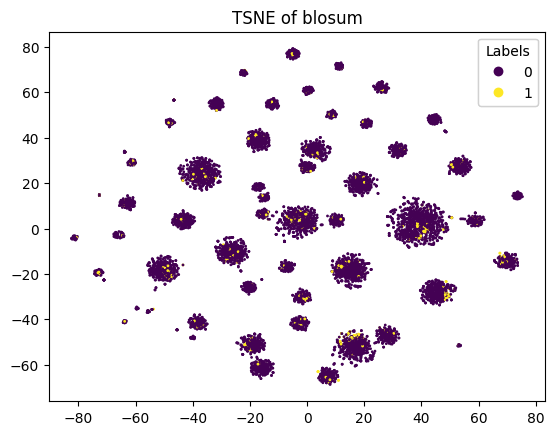

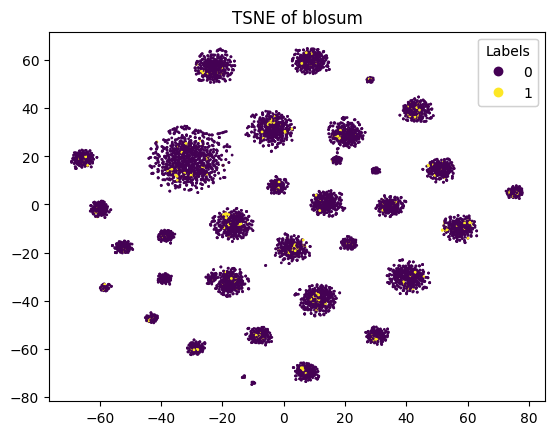

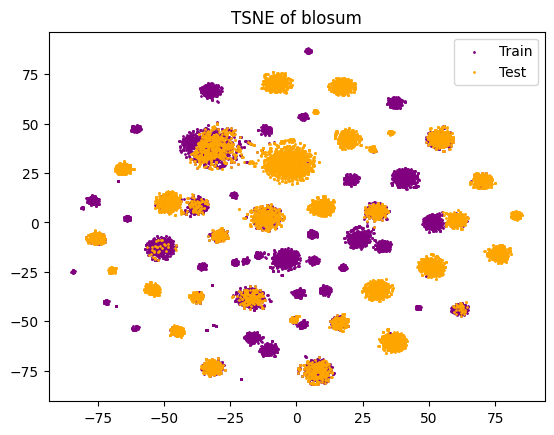

In [30]:
indices_plot_train = np.random.choice(len(X_train), 10000, replace=False)
plotting.plot2d(X_train[indices_plot_train], y_train[indices_plot_train], embd_method, method='tsne')

indices_plot_test = np.random.choice(len(X_test), 10000, replace=False)
plotting.plot2d(X_test[indices_plot_test], y_test[indices_plot_test], embd_method, method='tsne')
plotting.plot2d_train_test(X_train[indices_plot_test], X_test[indices_plot_test], embd_method, method='tsne')

We can conclude that 
* (1) and (2): The PepNet model struggles to separate the classes effectively, indicating that the feature space is not linearly separable. We will explore more advanced feature extraction techniques in Section 4.
* (3): The overlap suggests that the data distributions in the training and test sets are not identical. While some clusters overlap, the majority do not. This is beneficial because if our model performs well on the test data, it is likely to have learned to generalize effectively to unseen data.

# 3. Machine Learning

Now that we have the embeddings for both the training and test sets, let's train a machine learning classifier to predict peptide-MHC binding.

Given that our dataset is heavily imbalanced, let's compute class weights to enhance the training process.

In [9]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

print("Computed class weights:", class_weights)

Computed class weights: [0.52836747 9.31291162]


To further address the class imbalance, we will use boosting with the XGBoost framework.

In [10]:
print("Training...")
model = xgb.XGBClassifier(
    n_estimators=150,  
    max_depth = 15,
    scale_pos_weight=class_weights[1] / class_weights[0], 
    alpha = 0.1,
    random_state=42
)

model.fit(X_train, y_train)

print("Predicting...")

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test) 


Training...
Predicting...


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99    900725
           1       0.85      0.69      0.76     45416

    accuracy                           0.98    946141
   macro avg       0.92      0.84      0.87    946141
weighted avg       0.98      0.98      0.98    946141

Balanced Accuracy: 0.8411855215686473
F1 Score : 0.7595594574575304


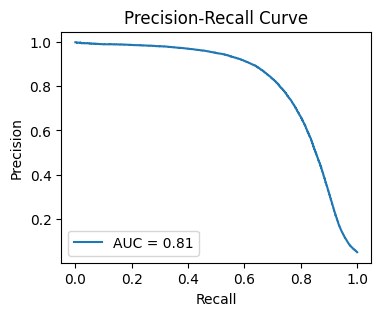

PR AUC : 0.8134279344682828


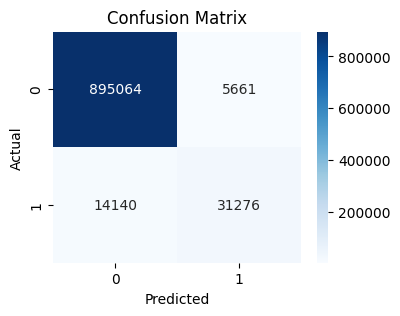

In [11]:
compute_metrics(y_test, y_pred, y_prob)

We achieved quite good results, especially considering that the embeddings are based on relatively simple encoding methods

Let's examine which peptides and alleles our model misclassified the most.

In [18]:
df_test = pd.read_csv("netmhcpan41_data/df_test_cleaned.csv")


misclassified_indices = np.where(y_test != y_pred)[0]
df_misclassified = df_test.iloc[misclassified_indices]
print(df_misclassified["peptide"].value_counts())
print("-------------------------------------------")
print(df_misclassified["allele"].value_counts())

peptide
TFTVTEKPEVID      36
TLKGETTTEAVD      34
TKTFTVTEKPEVID    34
TVTEKPEVID        32
SIPEKNRPL         31
                  ..
DALLKNQRR          1
DALTGHLR           1
DALVTIRNR          1
DAMKRIVGM          1
SILEVGDGVFEVKA     1
Name: count, Length: 17147, dtype: int64
-------------------------------------------
allele
YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH    1612
YYSEYREISTNTYESNLYLRYDSYTWAELAYLWY    1451
YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY    1304
YSAMYQENVAHTDENTLYIIYEHYTWARLAYTWY    1261
YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY    1164
YFAMYGEKVAHTHVDTLYLRYHYYTWAVWAYTWY     959
YYAMYGEKVAHTHVDTLYLRYHYYTWAVWAYTWY     915
YYAMYRNNVAQTDVDTLYIRYQDYTWAEWAYRWY     840
YFAMYGEKVAHIDVDTLYVRYHYYTWAVLAYTWY     782
YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY     778
YYAMYRENMASTYENIAYLRYHDYTWAELAYLWY     666
YYAGYREKYRQADVSNLYLWYDSYTWAEWAYTWY     624
YSAMYQENVAQTDVDTLYIIYEHYTWAWLAYTWY     600
YSAMYEEKVAHTDENIAYLMFHYYTWAVLAYTGY     597
YHSTYREISTNTYEDTLYIRSNFYTWAVDAYTWY     553
YYATYRNIFTNTYENIAYIRYDSY

We can see that the most misclassified allele is one of the four alleles that were not present in the training set (YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH). This suggests that our model is not generalizing well enough

# 4. Deep Learning

Now that we have trained a reasonably good classifier using basic encoding methods, let's focus on more advanced encoding techniques based on deep learning and protein language models.

## 4.1 ProtTrans


As first deep encoding method, we will use ProtTrans from the 2021 paper ['ProtTrans: Towards Cracking the Language of
Life’s Code Through Self-Supervised Learning'](https://arxiv.org/abs/2007.06225). 

ProtTrans uses advanced transformer architectures such as BERT (Bidirectional Encoder Representations from Transformers) and T5 (Text-To-Text Transfer Transformer) for protein sequence analysis. These models are pre-trained on large datasets of protein sequences to capture complex patterns and relationships.

In [2]:
embd_method = 'prottrans'

encoder = ProttransEncoder()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


First, we need to preprocess the peptide and allele protein sequences. To do this, we will map rarely occurring amino acids (U, Z, O, B) to 'X' and add spaces between amino acids. Given the large size of our datasets, applying such encoding methods using large neural networks is very time-consuming. Therefore, we will use only 1,000,000 rows from the training set (approximately one-third of the total) for this step.

In [23]:
df_train = pd.read_csv("netmhcpan41_data/df_train_cleaned.csv")
df_test = pd.read_csv("netmhcpan41_data/df_test_cleaned.csv")

indices_train = np.random.choice(len(df_train), 1000000, replace=False)

seqs = encoder.preprocess_sequences(df_train['peptide'][indices_train].values)
peptide_train_dataset = ProteinSequenceDataset(seqs)

seqs = encoder.preprocess_sequences(df_train['allele'][indices_train].values)
allele_train_dataset = ProteinSequenceDataset(seqs)

seqs = encoder.preprocess_sequences(df_test['peptide'].values)
peptide_test_dataset = ProteinSequenceDataset(seqs)

seqs = encoder.preprocess_sequences(df_test['allele'].values)
allele_test_dataset = ProteinSequenceDataset(seqs)

batch_size_p=1000
batch_size_a=1

peptide_train_loader  = DataLoader(peptide_train_dataset, shuffle=False, batch_size=batch_size_p)
allele_train_loader  = DataLoader(allele_train_dataset, shuffle=False, batch_size=batch_size_a)

peptide_test_loader  = DataLoader(peptide_test_dataset, shuffle=False, batch_size=batch_size_p)
allele_test_loader  = DataLoader(allele_test_dataset, shuffle=False, batch_size=batch_size_a)

y_train = np.array(df_train['hit'][indices_train])
y_test = np.array(df_test['hit'])

In [24]:
allele_test_dataset[0]

'Y Y A T Y R N I F T N T Y E S N L Y I R Y D F Y T W A V L A Y L W Y'

For allele encoding, since there are not many unique values, we will use a dictionary to store previously extracted embeddings. This will help speed up the process.

In [ ]:
ptrain = encoder.encode_sequences(peptide_train_loader, model, device)
np.save("./embeddings/ptrain_prottrans.npy", ptrain)
atrain = encoder.encode_sequences(allele_train_loader, model,device, keep_dict=True)
np.save("./embeddings/atrain_prottrans.npy", atrain)
np.save("./embeddings/y_train_prottrans.npy", y_train)

gc.collect()

ptest = encoder.encode_sequences(peptide_test_loader, model, device)
np.save("./embeddings/ptest_prottrans.npy", ptest)
atest = encoder.encode_sequences(allele_test_loader, model,device, keep_dict=True)
np.save("./embeddings/atest_prottrans.npy", atest)
np.save("./embeddings/y_test_prottrans.npy", y_test)


In [61]:
ptrain = np.load("./embeddings/ptrain_prottrans.npy").astype(np.float16)
atrain = np.load("./embeddings/atrain_prottrans.npy").astype(np.float16)
y_train = np.load("./embeddings/y_train_prottrans.npy")

ptest = np.load("./embeddings/ptest_prottrans.npy").astype(np.float16)
atest = np.load("./embeddings/atest_prottrans.npy").astype(np.float16)
y_test = np.load("./embeddings/y_test_prottrans.npy")

We have our allele and peptide embeddings. For the final step, we will concatenate the two. (I also tried averaging them since they are the same size, but the results were worse).

In [62]:
X_train = np.concatenate([ptrain,atrain], axis=1)
#X_train = (ptrain+atrain)/2
del ptrain
del atrain

X_test = np.concatenate([ptest,atest], axis=1)
#X_test = (ptest+ptest)/2
del ptest
del atest

In [63]:
X_train.shape

(1000000, 2048)

In [5]:
'''
# I tried to use PCA to reduce dim, but performances were worse

pca = PCA(n_components=512)
# Fit PCA on the training data
X_train = pca.fit_transform(X_train)#.astype(np.float16)

# Transform the test data using the fitted PCA
X_test = pca.transform(X_test)#.astype(np.float16)
'''

In [11]:
'''np.save("./embeddings/X_train_prottrans_pca512.npy", X_train.astype(np.float16))
np.save("./embeddings/y_train_prottrans_pca512.npy", y_train)
np.save("./embeddings/X_test_prottrans_pca512.npy", X_test.astype(np.float16))
np.save("./embeddings/y_test_prottrans_pca512.npy", y_test)'''

Let's plot a sample of our resulting embeddings in 2D space to visualize:
* (1): Whether the two classes overlap in the training set.
* (2): Whether the two classes overlap in the test set.
* (3): Whether there is overlap between the training and test sets."

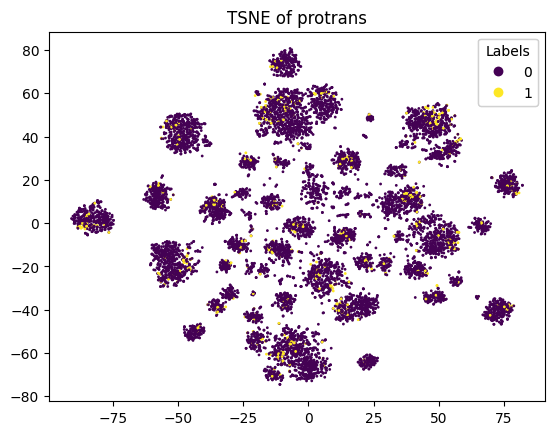

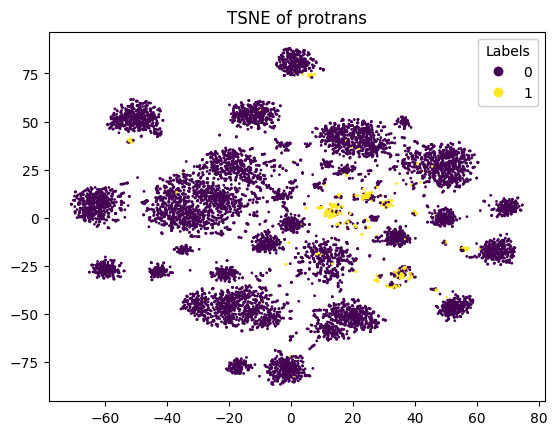

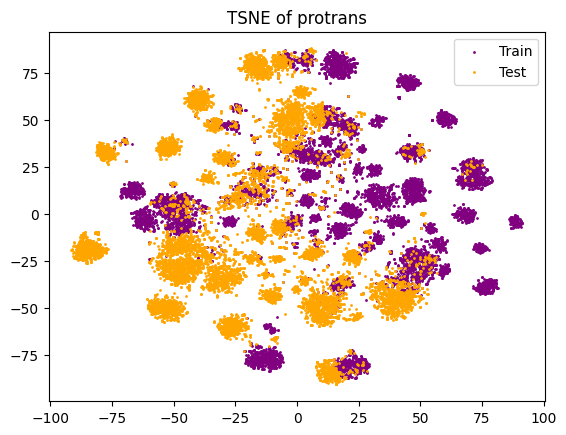

In [34]:
indices_plot_train = np.random.choice(len(X_train), 10000, replace=False)
plotting.plot2d(X_train[indices_plot_train], y_train[indices_plot_train], embd_method='protrans', method='tsne')

indices_plot_test = np.random.choice(len(X_test), 10000, replace=False)
plotting.plot2d(X_test[indices_plot_test], y_test[indices_plot_test], embd_method='protrans', method='tsne')

plotting.plot2d_train_test(X_train[indices_plot_train], X_test[indices_plot_test], embd_method='protrans', method='tsne')

We can conclude that 
* (1) and (2): Interestingly, the model struggles to separate the training set but performs better on the test set. This may indicate the presence of label noise in the training dataset.
* (3): The overlap suggests that the data distributions in the training and test sets are not identical. While some clusters overlap, the majority do not. This is beneficial because if our model performs well on the test data, it is likely to have learned to generalize effectively to unseen data.

Now that we have our embdeddings, let's train a linear neural network. 

Let's create validation dataset from train dataset.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print(X_train.shape)

In [64]:
class GaussianBlur():
    """
    Gaussian blur augmentation for embeddings.

    Args:
        sigma (float, optional): Standard deviation for Gaussian kernel. Default is 0.1.
    """
    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def __call__(self, input):
        s = np.random.uniform(0,self.sigma)
        return input+np.random.normal(size=input.shape, scale=s)


train_dataset = EmbeddingDataset(X_train, y_train, transform=GaussianBlur(sigma=0.01))
val_dataset = EmbeddingDataset(X_val, y_val)
test_dataset = EmbeddingDataset(X_test, y_test)

batch_size=50000
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

(800000, 2048)


In [66]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = torch.from_numpy(class_weights).type(torch.float32).to(device)
print(class_weights)

tensor([0.5285, 9.2777], device='cuda:0')


In [68]:
input_size = X_train.shape[1]
classifier = ClassificationHead(input_size=input_size, num_classes=2).to(device)

n_epoch=100
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0005, weight_decay=1.e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch)

train_model(device, classifier, train_loader, val_loader, criterion, optimizer, scheduler, n_epoch, patience=5)

Epoch 1/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 1 -> t_loss: 0.6035, v_loss: 0.509, bacc: 0.7573, precision:0.14, recall:0.79, f1:0.24


Epoch 2/100: 100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


epoch 2 -> t_loss: 0.4835, v_loss: 0.450, bacc: 0.8032, precision:0.17, recall:0.85, f1:0.28


Epoch 3/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 3 -> t_loss: 0.4332, v_loss: 0.405, bacc: 0.8293, precision:0.19, recall:0.87, f1:0.31


Epoch 4/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 4 -> t_loss: 0.3991, v_loss: 0.401, bacc: 0.8318, precision:0.16, recall:0.93, f1:0.28


Epoch 5/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 5 -> t_loss: 0.3810, v_loss: 0.381, bacc: 0.8377, precision:0.27, recall:0.80, f1:0.41


Epoch 6/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 6 -> t_loss: 0.3612, v_loss: 0.350, bacc: 0.8575, precision:0.20, recall:0.92, f1:0.33


Epoch 7/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 7 -> t_loss: 0.3417, v_loss: 0.332, bacc: 0.8647, precision:0.28, recall:0.85, f1:0.42


Epoch 8/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 8 -> t_loss: 0.3287, v_loss: 0.318, bacc: 0.8723, precision:0.30, recall:0.86, f1:0.44


Epoch 9/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 9 -> t_loss: 0.3110, v_loss: 0.300, bacc: 0.8813, precision:0.30, recall:0.88, f1:0.45


Epoch 10/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 10 -> t_loss: 0.3007, v_loss: 0.288, bacc: 0.8864, precision:0.31, recall:0.89, f1:0.46


Epoch 11/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 11 -> t_loss: 0.2919, v_loss: 0.275, bacc: 0.8916, precision:0.29, recall:0.91, f1:0.44


Epoch 12/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 12 -> t_loss: 0.2845, v_loss: 0.271, bacc: 0.8955, precision:0.32, recall:0.90, f1:0.48


Epoch 13/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 13 -> t_loss: 0.2741, v_loss: 0.266, bacc: 0.8941, precision:0.26, recall:0.94, f1:0.41


Epoch 14/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 14 -> t_loss: 0.2740, v_loss: 0.318, bacc: 0.8674, precision:0.48, recall:0.78, f1:0.59


Epoch 15/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 15 -> t_loss: 0.2786, v_loss: 0.262, bacc: 0.8944, precision:0.25, recall:0.95, f1:0.40


Epoch 16/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 16 -> t_loss: 0.2580, v_loss: 0.260, bacc: 0.8995, precision:0.40, recall:0.87, f1:0.55


Epoch 17/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 17 -> t_loss: 0.2518, v_loss: 0.245, bacc: 0.9030, precision:0.28, recall:0.94, f1:0.43


Epoch 18/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 18 -> t_loss: 0.2443, v_loss: 0.235, bacc: 0.9082, precision:0.32, recall:0.93, f1:0.47


Epoch 19/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 19 -> t_loss: 0.2395, v_loss: 0.232, bacc: 0.9098, precision:0.33, recall:0.93, f1:0.49


Epoch 20/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 20 -> t_loss: 0.2385, v_loss: 0.228, bacc: 0.9127, precision:0.36, recall:0.92, f1:0.52


Epoch 21/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 21 -> t_loss: 0.2316, v_loss: 0.227, bacc: 0.9138, precision:0.39, recall:0.91, f1:0.54


Epoch 22/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 22 -> t_loss: 0.2263, v_loss: 0.221, bacc: 0.9167, precision:0.36, recall:0.93, f1:0.52


Epoch 23/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 23 -> t_loss: 0.2238, v_loss: 0.227, bacc: 0.9150, precision:0.43, recall:0.90, f1:0.58


Epoch 24/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 24 -> t_loss: 0.2294, v_loss: 0.216, bacc: 0.9174, precision:0.35, recall:0.93, f1:0.51


Epoch 25/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 25 -> t_loss: 0.2206, v_loss: 0.218, bacc: 0.9193, precision:0.42, recall:0.91, f1:0.57


Epoch 26/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 26 -> t_loss: 0.2194, v_loss: 0.211, bacc: 0.9199, precision:0.37, recall:0.93, f1:0.53


Epoch 27/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 27 -> t_loss: 0.2124, v_loss: 0.209, bacc: 0.9199, precision:0.34, recall:0.94, f1:0.50


Epoch 28/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 28 -> t_loss: 0.2085, v_loss: 0.207, bacc: 0.9221, precision:0.39, recall:0.93, f1:0.55


Epoch 29/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 29 -> t_loss: 0.2109, v_loss: 0.230, bacc: 0.9081, precision:0.27, recall:0.97, f1:0.42


Epoch 30/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 30 -> t_loss: 0.2190, v_loss: 0.248, bacc: 0.9047, precision:0.56, recall:0.85, f1:0.67


Epoch 31/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 31 -> t_loss: 0.2254, v_loss: 0.203, bacc: 0.9237, precision:0.38, recall:0.94, f1:0.54


Epoch 32/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 32 -> t_loss: 0.2048, v_loss: 0.201, bacc: 0.9237, precision:0.36, recall:0.94, f1:0.52


Epoch 33/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 33 -> t_loss: 0.2001, v_loss: 0.199, bacc: 0.9254, precision:0.39, recall:0.93, f1:0.55


Epoch 34/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 34 -> t_loss: 0.1978, v_loss: 0.198, bacc: 0.9252, precision:0.38, recall:0.94, f1:0.54


Epoch 35/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 35 -> t_loss: 0.1963, v_loss: 0.198, bacc: 0.9263, precision:0.42, recall:0.92, f1:0.58


Epoch 36/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 36 -> t_loss: 0.1960, v_loss: 0.198, bacc: 0.9265, precision:0.43, recall:0.92, f1:0.59


Epoch 37/100: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


epoch 37 -> t_loss: 0.1960, v_loss: 0.199, bacc: 0.9267, precision:0.45, recall:0.92, f1:0.60


Epoch 38/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 38 -> t_loss: 0.1933, v_loss: 0.193, bacc: 0.9279, precision:0.41, recall:0.93, f1:0.57


Epoch 39/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 39 -> t_loss: 0.1938, v_loss: 0.195, bacc: 0.9259, precision:0.35, recall:0.95, f1:0.51


Epoch 40/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 40 -> t_loss: 0.1898, v_loss: 0.191, bacc: 0.9284, precision:0.39, recall:0.94, f1:0.55


Epoch 41/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 41 -> t_loss: 0.1903, v_loss: 0.194, bacc: 0.9256, precision:0.35, recall:0.95, f1:0.51


Epoch 42/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 42 -> t_loss: 0.1886, v_loss: 0.188, bacc: 0.9297, precision:0.42, recall:0.93, f1:0.58


Epoch 43/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 43 -> t_loss: 0.1893, v_loss: 0.191, bacc: 0.9271, precision:0.36, recall:0.95, f1:0.52


Epoch 44/100: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


epoch 44 -> t_loss: 0.1896, v_loss: 0.191, bacc: 0.9281, precision:0.36, recall:0.95, f1:0.52


Epoch 45/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 45 -> t_loss: 0.1879, v_loss: 0.190, bacc: 0.9299, precision:0.45, recall:0.92, f1:0.60


Epoch 46/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 46 -> t_loss: 0.1852, v_loss: 0.186, bacc: 0.9317, precision:0.42, recall:0.94, f1:0.58


Epoch 47/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 47 -> t_loss: 0.1827, v_loss: 0.188, bacc: 0.9279, precision:0.36, recall:0.95, f1:0.53


Epoch 48/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 48 -> t_loss: 0.1839, v_loss: 0.184, bacc: 0.9309, precision:0.40, recall:0.94, f1:0.56


Epoch 49/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 49 -> t_loss: 0.1806, v_loss: 0.188, bacc: 0.9315, precision:0.47, recall:0.92, f1:0.62


Epoch 50/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 50 -> t_loss: 0.1811, v_loss: 0.191, bacc: 0.9263, precision:0.34, recall:0.96, f1:0.50


Epoch 51/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 51 -> t_loss: 0.1826, v_loss: 0.183, bacc: 0.9322, precision:0.40, recall:0.94, f1:0.57


Epoch 52/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 52 -> t_loss: 0.1798, v_loss: 0.182, bacc: 0.9321, precision:0.43, recall:0.93, f1:0.59


Epoch 53/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 53 -> t_loss: 0.1797, v_loss: 0.184, bacc: 0.9305, precision:0.37, recall:0.95, f1:0.54


Epoch 54/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 54 -> t_loss: 0.1774, v_loss: 0.181, bacc: 0.9326, precision:0.41, recall:0.94, f1:0.58


Epoch 55/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 55 -> t_loss: 0.1759, v_loss: 0.184, bacc: 0.9300, precision:0.37, recall:0.95, f1:0.53


Epoch 56/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 56 -> t_loss: 0.1757, v_loss: 0.180, bacc: 0.9332, precision:0.44, recall:0.93, f1:0.60


Epoch 57/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 57 -> t_loss: 0.1743, v_loss: 0.180, bacc: 0.9339, precision:0.44, recall:0.94, f1:0.60


Epoch 58/100: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


epoch 58 -> t_loss: 0.1743, v_loss: 0.180, bacc: 0.9319, precision:0.39, recall:0.95, f1:0.55


Epoch 59/100: 100%|██████████| 16/16 [00:42<00:00,  2.69s/it]


epoch 59 -> t_loss: 0.1734, v_loss: 0.178, bacc: 0.9343, precision:0.42, recall:0.94, f1:0.58


Epoch 60/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 60 -> t_loss: 0.1728, v_loss: 0.178, bacc: 0.9344, precision:0.43, recall:0.94, f1:0.59


Epoch 61/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 61 -> t_loss: 0.1725, v_loss: 0.177, bacc: 0.9341, precision:0.43, recall:0.94, f1:0.59


Epoch 62/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 62 -> t_loss: 0.1714, v_loss: 0.178, bacc: 0.9348, precision:0.45, recall:0.93, f1:0.61


Epoch 63/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 63 -> t_loss: 0.1708, v_loss: 0.177, bacc: 0.9344, precision:0.44, recall:0.94, f1:0.60


Epoch 64/100: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


epoch 64 -> t_loss: 0.1702, v_loss: 0.177, bacc: 0.9331, precision:0.40, recall:0.95, f1:0.56


Epoch 65/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 65 -> t_loss: 0.1706, v_loss: 0.177, bacc: 0.9345, precision:0.44, recall:0.94, f1:0.60


Epoch 66/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 66 -> t_loss: 0.1697, v_loss: 0.180, bacc: 0.9346, precision:0.48, recall:0.93, f1:0.63


Epoch 67/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 67 -> t_loss: 0.1704, v_loss: 0.177, bacc: 0.9341, precision:0.45, recall:0.93, f1:0.61


Epoch 68/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 68 -> t_loss: 0.1687, v_loss: 0.177, bacc: 0.9345, precision:0.46, recall:0.93, f1:0.62


Epoch 69/100: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


epoch 69 -> t_loss: 0.1686, v_loss: 0.177, bacc: 0.9348, precision:0.47, recall:0.93, f1:0.63


Epoch 70/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 70 -> t_loss: 0.1674, v_loss: 0.175, bacc: 0.9351, precision:0.42, recall:0.95, f1:0.58


Epoch 71/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 71 -> t_loss: 0.1672, v_loss: 0.175, bacc: 0.9357, precision:0.45, recall:0.94, f1:0.60


Epoch 72/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 72 -> t_loss: 0.1665, v_loss: 0.177, bacc: 0.9352, precision:0.47, recall:0.93, f1:0.62


Epoch 73/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 73 -> t_loss: 0.1666, v_loss: 0.175, bacc: 0.9356, precision:0.45, recall:0.94, f1:0.61


Epoch 74/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 74 -> t_loss: 0.1659, v_loss: 0.174, bacc: 0.9357, precision:0.44, recall:0.94, f1:0.60


Epoch 75/100: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


epoch 75 -> t_loss: 0.1660, v_loss: 0.176, bacc: 0.9355, precision:0.47, recall:0.93, f1:0.62


Epoch 76/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 76 -> t_loss: 0.1654, v_loss: 0.175, bacc: 0.9361, precision:0.46, recall:0.93, f1:0.62


Epoch 77/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 77 -> t_loss: 0.1656, v_loss: 0.174, bacc: 0.9360, precision:0.44, recall:0.94, f1:0.60


Epoch 78/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 78 -> t_loss: 0.1652, v_loss: 0.174, bacc: 0.9364, precision:0.45, recall:0.94, f1:0.61


Epoch 79/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 79 -> t_loss: 0.1650, v_loss: 0.174, bacc: 0.9365, precision:0.44, recall:0.94, f1:0.60


Epoch 80/100: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]


epoch 80 -> t_loss: 0.1646, v_loss: 0.173, bacc: 0.9361, precision:0.43, recall:0.94, f1:0.59


Epoch 81/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 81 -> t_loss: 0.1648, v_loss: 0.174, bacc: 0.9361, precision:0.46, recall:0.93, f1:0.62


Epoch 82/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 82 -> t_loss: 0.1641, v_loss: 0.173, bacc: 0.9358, precision:0.42, recall:0.95, f1:0.58


Epoch 83/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 83 -> t_loss: 0.1638, v_loss: 0.173, bacc: 0.9364, precision:0.44, recall:0.94, f1:0.60


Epoch 84/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 84 -> t_loss: 0.1636, v_loss: 0.173, bacc: 0.9363, precision:0.45, recall:0.94, f1:0.61


Epoch 85/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 85 -> t_loss: 0.1634, v_loss: 0.173, bacc: 0.9363, precision:0.45, recall:0.94, f1:0.61


Epoch 86/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 86 -> t_loss: 0.1634, v_loss: 0.173, bacc: 0.9361, precision:0.45, recall:0.94, f1:0.61


Epoch 87/100: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


epoch 87 -> t_loss: 0.1634, v_loss: 0.173, bacc: 0.9367, precision:0.44, recall:0.94, f1:0.60


Epoch 88/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 88 -> t_loss: 0.1633, v_loss: 0.173, bacc: 0.9365, precision:0.45, recall:0.94, f1:0.60


Epoch 89/100: 100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


epoch 89 -> t_loss: 0.1633, v_loss: 0.173, bacc: 0.9362, precision:0.45, recall:0.94, f1:0.61


Epoch 90/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 90 -> t_loss: 0.1632, v_loss: 0.173, bacc: 0.9362, precision:0.45, recall:0.94, f1:0.61


Epoch 91/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 91 -> t_loss: 0.1629, v_loss: 0.173, bacc: 0.9366, precision:0.45, recall:0.94, f1:0.61


Epoch 92/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 92 -> t_loss: 0.1629, v_loss: 0.173, bacc: 0.9365, precision:0.44, recall:0.94, f1:0.60


Epoch 93/100: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


epoch 93 -> t_loss: 0.1631, v_loss: 0.172, bacc: 0.9366, precision:0.44, recall:0.94, f1:0.60


Epoch 94/100: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


epoch 94 -> t_loss: 0.1626, v_loss: 0.173, bacc: 0.9366, precision:0.45, recall:0.94, f1:0.61


Epoch 95/100: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


epoch 95 -> t_loss: 0.1624, v_loss: 0.172, bacc: 0.9364, precision:0.45, recall:0.94, f1:0.60


Epoch 96/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 96 -> t_loss: 0.1627, v_loss: 0.173, bacc: 0.9363, precision:0.45, recall:0.94, f1:0.60


Epoch 97/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 97 -> t_loss: 0.1628, v_loss: 0.173, bacc: 0.9365, precision:0.45, recall:0.94, f1:0.61


Epoch 98/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 98 -> t_loss: 0.1628, v_loss: 0.173, bacc: 0.9364, precision:0.45, recall:0.94, f1:0.61
Early Stopping: 5 epochs since last best val loss. Total epochs trained: 98


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    900725
           1       0.80      0.75      0.77     45416

    accuracy                           0.98    946141
   macro avg       0.90      0.87      0.88    946141
weighted avg       0.98      0.98      0.98    946141

Balanced Accuracy: 0.8691305053652663
F1 Score : 0.7747132994808011


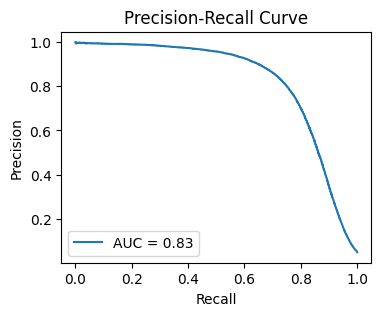

PR AUC : 0.8269523613969509


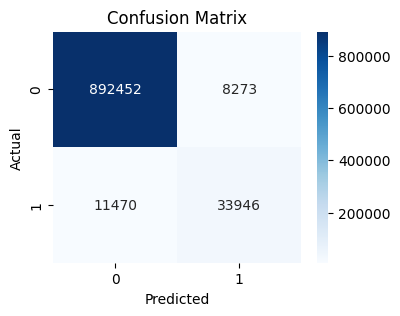

In [69]:
eval_model(device, classifier, test_loader)

Even with just one-third of the training dataset, we achieve slightly better results than in the previous section. This confirms the enhanced representation provided by ProtTrans.

Let's try using [Generalized Cross Entropy](https://arxiv.org/abs/1805.07836), a loss function resilient to label noise, to determine if noisy labels are limiting the effectiveness of our training.

In [70]:
classifier = ClassificationHead(input_size=input_size, num_classes=2).to(device)

n_epoch=100
criterion = GCE(num_classes=2, class_weights=class_weights)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0005, weight_decay=1.e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch)

t_loss, v_loss, v_acc, v_precision, v_recall, v_f1 = train_model(device, classifier, train_loader, val_loader, criterion, optimizer, scheduler, n_epoch, patience=5)

Epoch 1/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 1 -> t_loss: 0.4709, v_loss: 0.355, bacc: 0.7390, precision:0.12, recall:0.83, f1:0.21


Epoch 2/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 2 -> t_loss: 0.3172, v_loss: 0.284, bacc: 0.7910, precision:0.16, recall:0.82, f1:0.27


Epoch 3/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 3 -> t_loss: 0.2709, v_loss: 0.267, bacc: 0.8059, precision:0.23, recall:0.76, f1:0.35


Epoch 4/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 4 -> t_loss: 0.2492, v_loss: 0.234, bacc: 0.8322, precision:0.20, recall:0.87, f1:0.32


Epoch 5/100: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


epoch 5 -> t_loss: 0.2320, v_loss: 0.225, bacc: 0.8393, precision:0.19, recall:0.90, f1:0.31


Epoch 6/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 6 -> t_loss: 0.2236, v_loss: 0.216, bacc: 0.8458, precision:0.22, recall:0.86, f1:0.35


Epoch 7/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 7 -> t_loss: 0.2156, v_loss: 0.211, bacc: 0.8496, precision:0.20, recall:0.91, f1:0.33


Epoch 8/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 8 -> t_loss: 0.2129, v_loss: 0.206, bacc: 0.8529, precision:0.24, recall:0.87, f1:0.37


Epoch 9/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 9 -> t_loss: 0.2058, v_loss: 0.201, bacc: 0.8581, precision:0.23, recall:0.89, f1:0.36


Epoch 10/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 10 -> t_loss: 0.2020, v_loss: 0.202, bacc: 0.8568, precision:0.25, recall:0.86, f1:0.39


Epoch 11/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 11 -> t_loss: 0.2009, v_loss: 0.194, bacc: 0.8625, precision:0.22, recall:0.90, f1:0.36


Epoch 12/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 12 -> t_loss: 0.1987, v_loss: 0.204, bacc: 0.8530, precision:0.19, recall:0.94, f1:0.31


Epoch 13/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 13 -> t_loss: 0.1943, v_loss: 0.188, bacc: 0.8665, precision:0.23, recall:0.90, f1:0.37


Epoch 14/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 14 -> t_loss: 0.1894, v_loss: 0.185, bacc: 0.8694, precision:0.25, recall:0.90, f1:0.39


Epoch 15/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 15 -> t_loss: 0.1913, v_loss: 0.188, bacc: 0.8669, precision:0.28, recall:0.86, f1:0.42


Epoch 16/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 16 -> t_loss: 0.1970, v_loss: 0.224, bacc: 0.8373, precision:0.34, recall:0.76, f1:0.47


Epoch 17/100: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


epoch 17 -> t_loss: 0.1955, v_loss: 0.186, bacc: 0.8670, precision:0.28, recall:0.86, f1:0.42


Epoch 18/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 18 -> t_loss: 0.1827, v_loss: 0.181, bacc: 0.8735, precision:0.28, recall:0.88, f1:0.42


Epoch 19/100: 100%|██████████| 16/16 [00:42<00:00,  2.69s/it]


epoch 19 -> t_loss: 0.1778, v_loss: 0.175, bacc: 0.8779, precision:0.25, recall:0.92, f1:0.39


Epoch 20/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 20 -> t_loss: 0.1774, v_loss: 0.175, bacc: 0.8764, precision:0.23, recall:0.93, f1:0.37


Epoch 21/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 21 -> t_loss: 0.1766, v_loss: 0.172, bacc: 0.8791, precision:0.24, recall:0.93, f1:0.38


Epoch 22/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 22 -> t_loss: 0.1725, v_loss: 0.168, bacc: 0.8833, precision:0.26, recall:0.91, f1:0.41


Epoch 23/100: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]


epoch 23 -> t_loss: 0.1700, v_loss: 0.169, bacc: 0.8830, precision:0.29, recall:0.89, f1:0.44


Epoch 24/100: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


epoch 24 -> t_loss: 0.1690, v_loss: 0.167, bacc: 0.8827, precision:0.24, recall:0.93, f1:0.38


Epoch 25/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 25 -> t_loss: 0.1657, v_loss: 0.164, bacc: 0.8859, precision:0.29, recall:0.89, f1:0.44


Epoch 26/100: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


epoch 26 -> t_loss: 0.1630, v_loss: 0.160, bacc: 0.8895, precision:0.29, recall:0.91, f1:0.44


Epoch 27/100: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]


epoch 27 -> t_loss: 0.1625, v_loss: 0.170, bacc: 0.8828, precision:0.34, recall:0.86, f1:0.49


Epoch 28/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 28 -> t_loss: 0.1613, v_loss: 0.157, bacc: 0.8905, precision:0.26, recall:0.93, f1:0.41


Epoch 29/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 29 -> t_loss: 0.1708, v_loss: 0.161, bacc: 0.8862, precision:0.31, recall:0.89, f1:0.46


Epoch 30/100: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


epoch 30 -> t_loss: 0.1633, v_loss: 0.155, bacc: 0.8926, precision:0.31, recall:0.90, f1:0.47


Epoch 31/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 31 -> t_loss: 0.1541, v_loss: 0.151, bacc: 0.8948, precision:0.28, recall:0.93, f1:0.43


Epoch 32/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 32 -> t_loss: 0.1516, v_loss: 0.151, bacc: 0.8941, precision:0.27, recall:0.93, f1:0.42


Epoch 33/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 33 -> t_loss: 0.1511, v_loss: 0.152, bacc: 0.8928, precision:0.26, recall:0.94, f1:0.40


Epoch 34/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 34 -> t_loss: 0.1492, v_loss: 0.149, bacc: 0.8944, precision:0.26, recall:0.94, f1:0.41


Epoch 35/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 35 -> t_loss: 0.1473, v_loss: 0.144, bacc: 0.9015, precision:0.31, recall:0.92, f1:0.47


Epoch 36/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 36 -> t_loss: 0.1530, v_loss: 0.149, bacc: 0.8982, precision:0.35, recall:0.89, f1:0.50


Epoch 37/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 37 -> t_loss: 0.1488, v_loss: 0.146, bacc: 0.8963, precision:0.26, recall:0.94, f1:0.41


Epoch 38/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 38 -> t_loss: 0.1438, v_loss: 0.143, bacc: 0.9040, precision:0.35, recall:0.90, f1:0.50


Epoch 39/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 39 -> t_loss: 0.1421, v_loss: 0.139, bacc: 0.9035, precision:0.30, recall:0.93, f1:0.46


Epoch 40/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 40 -> t_loss: 0.1400, v_loss: 0.138, bacc: 0.9040, precision:0.31, recall:0.93, f1:0.46


Epoch 41/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 41 -> t_loss: 0.1397, v_loss: 0.137, bacc: 0.9049, precision:0.31, recall:0.93, f1:0.46


Epoch 42/100: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


epoch 42 -> t_loss: 0.1382, v_loss: 0.141, bacc: 0.9071, precision:0.38, recall:0.90, f1:0.54


Epoch 43/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 43 -> t_loss: 0.1385, v_loss: 0.135, bacc: 0.9078, precision:0.34, recall:0.92, f1:0.49


Epoch 44/100: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


epoch 44 -> t_loss: 0.1355, v_loss: 0.134, bacc: 0.9084, precision:0.33, recall:0.93, f1:0.48


Epoch 45/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 45 -> t_loss: 0.1336, v_loss: 0.133, bacc: 0.9106, precision:0.35, recall:0.92, f1:0.51


Epoch 46/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 46 -> t_loss: 0.1334, v_loss: 0.132, bacc: 0.9106, precision:0.34, recall:0.92, f1:0.50


Epoch 47/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 47 -> t_loss: 0.1319, v_loss: 0.131, bacc: 0.9103, precision:0.33, recall:0.93, f1:0.49


Epoch 48/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 48 -> t_loss: 0.1311, v_loss: 0.130, bacc: 0.9114, precision:0.34, recall:0.93, f1:0.49


Epoch 49/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 49 -> t_loss: 0.1312, v_loss: 0.129, bacc: 0.9125, precision:0.35, recall:0.92, f1:0.50


Epoch 50/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 50 -> t_loss: 0.1291, v_loss: 0.128, bacc: 0.9124, precision:0.33, recall:0.93, f1:0.49


Epoch 51/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 51 -> t_loss: 0.1284, v_loss: 0.129, bacc: 0.9107, precision:0.31, recall:0.94, f1:0.47


Epoch 52/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 52 -> t_loss: 0.1291, v_loss: 0.127, bacc: 0.9130, precision:0.33, recall:0.93, f1:0.49


Epoch 53/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 53 -> t_loss: 0.1271, v_loss: 0.126, bacc: 0.9141, precision:0.35, recall:0.93, f1:0.50


Epoch 54/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 54 -> t_loss: 0.1261, v_loss: 0.126, bacc: 0.9144, precision:0.34, recall:0.93, f1:0.49


Epoch 55/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 55 -> t_loss: 0.1256, v_loss: 0.126, bacc: 0.9162, precision:0.38, recall:0.92, f1:0.53


Epoch 56/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 56 -> t_loss: 0.1253, v_loss: 0.126, bacc: 0.9160, precision:0.38, recall:0.92, f1:0.54


Epoch 57/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 57 -> t_loss: 0.1256, v_loss: 0.124, bacc: 0.9160, precision:0.34, recall:0.94, f1:0.50


Epoch 58/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 58 -> t_loss: 0.1243, v_loss: 0.124, bacc: 0.9169, precision:0.36, recall:0.93, f1:0.52


Epoch 59/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 59 -> t_loss: 0.1241, v_loss: 0.129, bacc: 0.9156, precision:0.42, recall:0.90, f1:0.57


Epoch 60/100: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


epoch 60 -> t_loss: 0.1238, v_loss: 0.123, bacc: 0.9174, precision:0.36, recall:0.93, f1:0.52


Epoch 61/100: 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


epoch 61 -> t_loss: 0.1227, v_loss: 0.123, bacc: 0.9182, precision:0.38, recall:0.92, f1:0.53


Epoch 62/100: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


epoch 62 -> t_loss: 0.1216, v_loss: 0.122, bacc: 0.9183, precision:0.38, recall:0.92, f1:0.54


Epoch 63/100: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


epoch 63 -> t_loss: 0.1222, v_loss: 0.122, bacc: 0.9185, precision:0.37, recall:0.93, f1:0.53


Epoch 64/100: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


epoch 64 -> t_loss: 0.1211, v_loss: 0.121, bacc: 0.9185, precision:0.36, recall:0.93, f1:0.52


Epoch 65/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 65 -> t_loss: 0.1207, v_loss: 0.121, bacc: 0.9182, precision:0.35, recall:0.93, f1:0.51


Epoch 66/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 66 -> t_loss: 0.1201, v_loss: 0.121, bacc: 0.9193, precision:0.38, recall:0.92, f1:0.54


Epoch 67/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 67 -> t_loss: 0.1197, v_loss: 0.120, bacc: 0.9196, precision:0.37, recall:0.93, f1:0.53


Epoch 68/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 68 -> t_loss: 0.1197, v_loss: 0.120, bacc: 0.9201, precision:0.37, recall:0.93, f1:0.53


Epoch 69/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 69 -> t_loss: 0.1192, v_loss: 0.120, bacc: 0.9200, precision:0.38, recall:0.92, f1:0.54


Epoch 70/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 70 -> t_loss: 0.1189, v_loss: 0.120, bacc: 0.9200, precision:0.36, recall:0.93, f1:0.52


Epoch 71/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 71 -> t_loss: 0.1184, v_loss: 0.119, bacc: 0.9202, precision:0.37, recall:0.93, f1:0.53


Epoch 72/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 72 -> t_loss: 0.1184, v_loss: 0.119, bacc: 0.9196, precision:0.35, recall:0.94, f1:0.51


Epoch 73/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 73 -> t_loss: 0.1182, v_loss: 0.119, bacc: 0.9203, precision:0.36, recall:0.94, f1:0.52


Epoch 74/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 74 -> t_loss: 0.1177, v_loss: 0.119, bacc: 0.9209, precision:0.37, recall:0.93, f1:0.53


Epoch 75/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 75 -> t_loss: 0.1174, v_loss: 0.118, bacc: 0.9204, precision:0.36, recall:0.94, f1:0.52


Epoch 76/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 76 -> t_loss: 0.1174, v_loss: 0.119, bacc: 0.9215, precision:0.38, recall:0.93, f1:0.54


Epoch 77/100: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


epoch 77 -> t_loss: 0.1172, v_loss: 0.118, bacc: 0.9210, precision:0.37, recall:0.93, f1:0.53


Epoch 78/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 78 -> t_loss: 0.1169, v_loss: 0.118, bacc: 0.9215, precision:0.38, recall:0.93, f1:0.54


Epoch 79/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 79 -> t_loss: 0.1167, v_loss: 0.118, bacc: 0.9213, precision:0.37, recall:0.93, f1:0.53


Epoch 80/100: 100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


epoch 80 -> t_loss: 0.1166, v_loss: 0.118, bacc: 0.9218, precision:0.37, recall:0.93, f1:0.53


Epoch 81/100: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


epoch 81 -> t_loss: 0.1165, v_loss: 0.118, bacc: 0.9215, precision:0.38, recall:0.93, f1:0.54


Epoch 82/100: 100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


epoch 82 -> t_loss: 0.1160, v_loss: 0.117, bacc: 0.9214, precision:0.37, recall:0.93, f1:0.53


Epoch 83/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 83 -> t_loss: 0.1162, v_loss: 0.117, bacc: 0.9218, precision:0.37, recall:0.94, f1:0.53


Epoch 84/100: 100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


epoch 84 -> t_loss: 0.1163, v_loss: 0.118, bacc: 0.9210, precision:0.35, recall:0.94, f1:0.51


Epoch 85/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 85 -> t_loss: 0.1161, v_loss: 0.117, bacc: 0.9215, precision:0.36, recall:0.94, f1:0.52


Epoch 86/100: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


epoch 86 -> t_loss: 0.1157, v_loss: 0.117, bacc: 0.9219, precision:0.37, recall:0.93, f1:0.53


Epoch 87/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 87 -> t_loss: 0.1158, v_loss: 0.117, bacc: 0.9216, precision:0.36, recall:0.94, f1:0.52


Epoch 88/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 88 -> t_loss: 0.1157, v_loss: 0.117, bacc: 0.9224, precision:0.38, recall:0.93, f1:0.54


Epoch 89/100: 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


epoch 89 -> t_loss: 0.1154, v_loss: 0.117, bacc: 0.9224, precision:0.37, recall:0.93, f1:0.53


Epoch 90/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 90 -> t_loss: 0.1155, v_loss: 0.117, bacc: 0.9225, precision:0.38, recall:0.93, f1:0.54


Epoch 91/100: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


epoch 91 -> t_loss: 0.1152, v_loss: 0.117, bacc: 0.9223, precision:0.38, recall:0.93, f1:0.54


Epoch 92/100: 100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


epoch 92 -> t_loss: 0.1150, v_loss: 0.117, bacc: 0.9225, precision:0.38, recall:0.93, f1:0.54


Epoch 93/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 93 -> t_loss: 0.1153, v_loss: 0.117, bacc: 0.9223, precision:0.37, recall:0.93, f1:0.53


Epoch 94/100: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


epoch 94 -> t_loss: 0.1150, v_loss: 0.117, bacc: 0.9225, precision:0.38, recall:0.93, f1:0.54


Epoch 95/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 95 -> t_loss: 0.1150, v_loss: 0.117, bacc: 0.9226, precision:0.38, recall:0.93, f1:0.54


Epoch 96/100: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


epoch 96 -> t_loss: 0.1152, v_loss: 0.117, bacc: 0.9224, precision:0.38, recall:0.93, f1:0.54


Epoch 97/100: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


epoch 97 -> t_loss: 0.1153, v_loss: 0.117, bacc: 0.9224, precision:0.38, recall:0.93, f1:0.54


Epoch 98/100: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


epoch 98 -> t_loss: 0.1150, v_loss: 0.117, bacc: 0.9226, precision:0.38, recall:0.93, f1:0.54
Early Stopping: 5 epochs since last best val loss. Total epochs trained: 98


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    900725
           1       0.86      0.74      0.80     45416

    accuracy                           0.98    946141
   macro avg       0.92      0.87      0.89    946141
weighted avg       0.98      0.98      0.98    946141

Balanced Accuracy: 0.8679360802448528
F1 Score : 0.7952480947549725


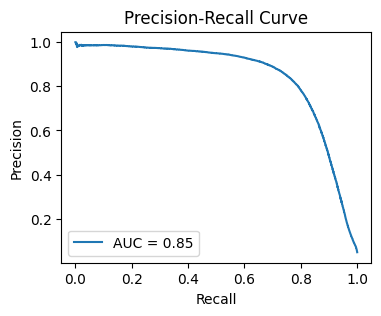

PR AUC : 0.8481533503614923


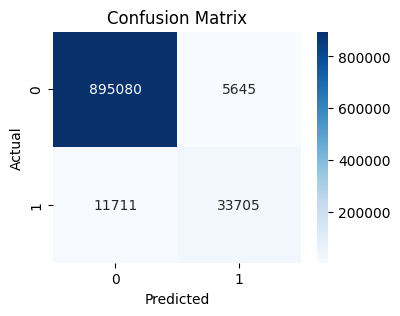

In [79]:
eval_model(device, classifier, test_loader)

We observe that the results are slightly better with the GCE loss. This may indicate the presence of noisy labels in the training dataset. However, since the improvement is not substantial, it could also be due to random variations during training.

## 4.2 MHCflurry

In this second part, we will focuss on MHCflurry model from paper [MHCflurry 2.0: Improved Pan-Allele Prediction of MHC Class I-Presented Peptides by Incorporating Antigen Processing](https://www.sciencedirect.com/science/article/pii/S2405471220302398). I choose this method because, unlike previous ones, it take as input HLA alleles directly and not pseudo sequences. It also manages the classifier part. 

In [ ]:
!pip install -q mhcflurry
!mhcflurry-downloads --quiet fetch models_class1_presentation

Since this method takes a long time to encode, we will test it on only 10,000 samples.

In [16]:
predictor = mhcflurry.Class1PresentationPredictor.load()

df_test = pd.read_csv("netmhcpan41_data/df_test_cleaned_HLA.csv")
indices_test = np.random.choice(len(df_test), 10000, replace=False)
df_test = df_test.iloc[indices_test]

alleles_test = df_test['allele'].str.replace('HLA-', '').values#[indices_test]
peptides_test = df_test['peptide'].values#[indices_test]
label_test = df_test['hit'].values#[indices_test]

One particularity of MHCflurry is that it do not take more than 6 alleles per batch. 

In [17]:
batch_size = 6
num_batchs = int(np.ceil(len(df_test) / batch_size))
all_scores = np.empty(len(df_test))
index_max = len(df_test)

for i in range(num_batchs):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, index_max)
    peptides_batch = peptides_test[start_index:end_index]
    alleles_batch = alleles_test[start_index:end_index]

    chunk_scores = predictor.predict(peptides_batch, alleles_batch, verbose=0)['presentation_score'].values
    all_scores[start_index:end_index] = chunk_scores.flatten()

1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 1s 870ms/step


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      9497
           1       0.54      0.84      0.66       503

    accuracy                           0.96     10000
   macro avg       0.77      0.90      0.82     10000
weighted avg       0.97      0.96      0.96     10000

Balanced Accuracy: 0.9036697996709644
F1 Score : 0.6614785992217899


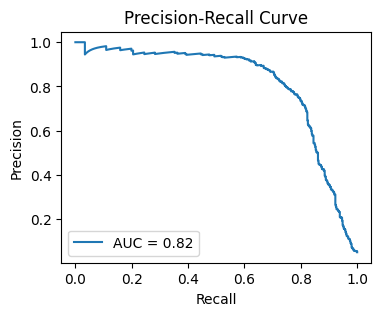

PR AUC : 0.8154302388335405


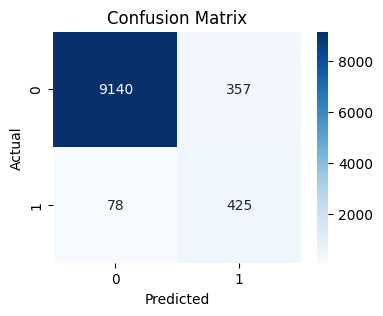

In [20]:
y_pred = np.array([1 if score>0.5 else 0 for score in all_scores])
y_test = label_test 

compute_metrics(y_test, y_pred, all_scores)

# 5. Conclusion & possible improvements

## 5.1 Results analysis

In this work, we compared multiple methods for predicting MHC-I presentation. 

We evaluated various traditional encoding methods from Pepnet framework, and we also explored a deep learning-based approach using ProtTrans, a protein language model. 

For classification, we used the XGBoost framework with the traditional encodings and a PyTorch linear classifier with the ProtTrans embeddings. Additionally, we utilized the MHCflurry framework, a pre-trained model, for comparison.

| Method         | Balanced Accuracy | Precision-Recall AUC | F1 Score |
|----------------|-------------------|----------------------|----------|
| XGBoost(index)       | 0.838            | 0.809                 | 0.758     |
| XGBoost(FOFE)       | 0.832             | 0.791                 | 0.739    |
| XGBoost(BLOSUM)       | 0.841             | 0.813                | 0.760     |
| LinearNN+CE(ProtTrans)       | 0.869             | 0.827                | 0.777    |
| LinearNN+GCE(ProtTrans)       | 0.868              | **0.848**                | **0.795**     |
| MHCflurry       | **0.904**            | 0.815                | 0.661     |


Due to limited time setting and computing ressources, these results are only based on one run (one seed, one train/val split,...), so their may not represent well the true performances. Furthermore, let's remind that for ProtTrans we've only take 1,000,000 training sample (1/3 of train set) and that for MHCflurry we could only test it on 10000 samples.

In addition, I've spent some time tuning the right hyperparameters, but I think there's still room for improvement.

Finally, fine-tuning ProtTrans and MHCflurry should give better results.

I believe the key to this technical test was to generate meaningful embeddings rather than to build the best classifier. Indeed, classification merely leverages the quality of the embeddings. 

## 5.2 Other interesting approachs

In my bibliography, I found other interesting approaches that I would have liked to test with more time:

[MHCfovea](https://www.nature.com/articles/s42003-021-02716-8) 

[Natural Language Inference (NLI) with double pretrain ESM](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10469926/)

[MHCRoBERTa](https://academic.oup.com/bib/article/23/3/bbab595/6571528)

[ConvMHC](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-017-1997-x)

## 5.3 Conclusion

I hope my notebook was clear and easy to follow. Through this exercise, I gained valuable insights into working with protein data and thoroughly enjoyed the experience.